In [83]:
# Importing relevant libraries

import pickle
import warnings
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
warnings.simplefilter(action='ignore', category=Warning) # Suppress warnings
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score




In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Data Preparation & Feature Extraction

In [3]:
# To display all the columns of the dataset:
pd.set_option('display.max_columns', None)
data_male_players= pd.read_csv('/content/drive/My Drive/Colab Notebooks/male_players_legacy.csv')
data_players_22= pd.read_csv('/content/drive/My Drive/Colab Notebooks/players_22.csv')


In [4]:
male_players = pd.DataFrame(data_male_players)
players_22 = pd.DataFrame(data_players_22)

In [5]:
male_players.head()

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,158023,/player/158023/lionel-messi/150002,15,2,2014-09-18,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,100500000.0,550000.0,27,1987-06-24,169,67,53.0,La Liga,1.0,241.0,FC Barcelona,CF,10.0,NaN,2004-07-01,2018.0,52,Argentina,1369.0,CF,10.0,Left,3,4,5,Medium/Low,Normal (170-),Yes,NaN,"#Speedster, #Dribbler, #FK Specialist, #Acroba...","Finesse Shot, Speed Dribbler (AI), One Club Pl...",93.0,89.0,86.0,96.0,27.0,63.0,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,NaN,25,21,20,6,11,15,14,8,NaN,89+3,89+3,89+3,92+3,90+3,90+3,90+3,92+3,92+3,92+3,92+3,90+3,79+3,79+3,79+3,90+3,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3,15+3,https://cdn.sofifa.net/players/158/023/15_120.png
1,20801,/player/20801/c-ronaldo-dos-santos-aveiro/150002,15,2,2014-09-18,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,79000000.0,375000.0,29,1985-02-05,185,80,53.0,La Liga,1.0,243.0,Real Madrid CF,LW,7.0,NaN,2009-07-01,2018.0,38,Portugal,1354.0,LW,7.0,Right,4,5,5,High/Low,Normal (185+),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",93.0,93.0,81.0,91.0,32.0,79.0,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,NaN,22,31,23,7,11,15,14,11,NaN,91+1,91+1,91+1,89+3,91+1,91+1,91+1,89+3,89+3,89+3,89+3,87+3,77+3,77+3,77+3,87+3,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3,16+3,https://cdn.sofifa.net/players/020/801/15_120.png
2,9014,/player/9014/arjen-robben/150002,15,2,2014-09-18,A. Robben,Arjen Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,1984-01-23,180,80,19.0,Bundesliga,1.0,21.0,FC Bayern München,SUB,10.0,NaN,2009-08-28,2017.0,34,Netherlands,105035.0,RS,11.0,Left,2,4,5,High/Low,Normal (170-185),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Diver, Injury Prone, Avoids Using Weaker Foot,...",93.0,86.0,83.0,92.0,32.0,64.0,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,NaN,84+3,84+3,84+3,88+2,87+3,87+3,87+3,88+2,88+2,88+2,88+2,87+3,78+3,78+3,78+3,87+3,64+3,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3,14+3,https://cdn.sofifa.net/players/009/014/15_120.png
3,41236,/player/41236/zlatan-ibrahimovic/150002,15,2,2014-09-18,Z. Ibrahimović,Zlatan Ibrahimović,ST,90,90,52500000.0,275000.0,32,1981-10-03,195,95,16.0,Ligue 1,1.0,73.0,Paris Saint-Germain,ST,10.0,NaN,2012-07-01,2016.0,46,Sweden,1363.0,ST,10.0,Right,4,4,5,Medium/Low,Normal (185+),Yes,NaN,"#Poacher, #Aerial Threat, #Distance Shooter, #...","Power Free-Kick, Leadership, Flair, Long Shot ...",76.0,91.0,81.0,86.0,34.0,86.0,76,91,76,84

In [6]:
players_22.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Low,Unique,Yes,144300000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,9.0,NaN,2014-07-01,2023.0,37,Poland,1353.0,RS,9.0,Right,4,4,5,High/Medium,Unique,Yes,197200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,11.0,Manchester United,English Premier League,1.0,ST,7.0,NaN,2021-08-27,2023.0,38,Portugal,1354.0,ST,7.0,Right,4,5,5,High/Low,Unique,Yes,83300000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


In [7]:
male_players.describe()

,player_id,fifa_version,fifa_update,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_id,league_level,club_team_id,club_jersey_number,club_contract_valid_until_year,nationality_id,nation_team_id,nation_jersey_number,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,161583.000000,161583.000000,161583.0,161583.000000,161583.000000,1.595300e+05,159822.000000,161583.000000,161583.000000,161583.000000,159810.000000,158866.000000,159810.000000,159810.000000,159810.000000,161583.000000,9316.000000,9316.000000,161583.000000,161583.000000,161583.000000,1.036220e+05,143614.000000,143614.000000,143614.000000,143614.000000,143614.000000,143614.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.000000,161583.00000,161583.000000,128722.000000,161583.000000,161583.000000,161583.000000,161583.00000,161583.000000,161583.000000,161583.000000,161583.000000,17969.000000
mean,214484.722353,19.125514,2.0,65.699071,70.744008,2.326770e+06,10855.409768,25.123181,181.240205,75.235031,210.409017,1.380283,44914.264783,20.161323,2020.352418,55.570462,30414.309790,12.094354,2.939480,2.329905,1.107140,4.797334e+06,68.022672,52.230764,56.938175,62.081872,51.133323,64.814364,49.658875,45.617738,52.250552,58.362334,43.035121,55.220524,47.305230,43.059233,52.602254,58.206686,64.707420,64.879257,63.379149,61.576824,63.942531,56.719098,64.942816,63.090795,65.152374,47.152708,55.701757,46.583032,49.996460,53.06687,48.668492,57.816892,45.757957,47.669996,45.698588,16.52961,16.274918,16.140374,16.288861,16.636973,39.149090
std,34928.608856,2.559318,0.0,7.040855,6.259121,6.005746e+06,21941.656285,4.670207,6.750148,7.000456,444.685024,0.750646,53413.302607,16.870350,2.662184,47.891746,48296.823056,6.720156,0.662863,0.751792,0.383605,1.231500e+07,11.096042,13.921947,10.484536,10.301293,16.639606,9.737047,18.002046,19.227861,17.127721,14.685893,17.431618,18.593406,18.076438,17.228577,15.226187,16.566549,14.720619,14.472380,14.691549,9.170063,14.025247,15.522391,11.899687,15.820791,12.613079,19.010437,17.219537,20.381661,19.171899,14.26859,15.652208,12.329739,20.453699,21.336404,20.935273,17.67047,16.834294,16.476466,16.998697,17.980143,10.503788
min,2.000000,15.000000,2.0,40.000000,40.000000,1.000000e+03,500.000000,16.000000,154.000000,49.000000,1.000000,1.000000,1.000000,1.000000,2014.000000,1.000000,974.000000,1.000000,1.000000,1.000000,1.000000,9.000000e+03,21.000000,14.000000,20.000000,22.000000,14.000000,27.000000,5.000000,2.000000,4.000000,7.000000,3.000000,2.000000,4.000000,3.000000,5.000000,5.000000,11.000000,11.000000,11.000000,20.000000,10.000000,2.000000,13.000000,10.000000,12.000000,3.000000,2.000000,3.000000,2.000000,3.00000,5.000000,3.000000,1.000000,2.000000,3.000000,1.00000,1.000000,1.000000,1.000000,1.000000,12.000000
25%,199159.000000,17.000000,2.0,61.000000,66.000000,3.250000e+05,2000.000000,21.000000,176.000000,70.000000,19.000000,1.000000,450.000000,8.000000,2018.000000,21.000000,1343.000000,6.000000,3.000000,2.000000

In [8]:
# gives a description of the dataset player_21
players_22.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_jersey_number,club_contract_valid_until,nationality_id,nation_team_id,nation_jersey_number,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,19239.000000,19239.000000,19239.000000,1.916500e+04,19178.000000,19239.000000,19239.000000,19239.000000,19178.000000,19178.000000,19178.000000,19178.000000,19239.000000,759.000000,759.000000,19239.000000,19239.000000,19239.000000,1.806300e+04,17107.000000,17107.000000,17107.000000,17107.000000,17107.000000,17107.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,2132.000000
mean,231468.086959,65.772182,71.079370,2.850452e+06,9017.989363,25.210822,181.299704,74.943032,50580.498123,1.354364,20.945250,2022.764000,58.602682,14480.848485,12.567852,2.946151,2.352461,1.094184,5.374044e+06,68.213071,52.345297,57.312562,62.561174,51.703630,64.823289,49.577421,45.894433,51.783877,58.867977,42.463849,55.660429,47.268933,42.249025,53.072249,58.472010,64.652893,64.714902,63.500078,61.450023,64.068611,57.776860,64.813504,63.084880,65.007745,46.642705,55.538957,46.613545,50.330215,53.964603,47.858724,57.929830,46.601746,48.045584,45.906700,16.406102,16.192474,16.055356,16.229274,16.491814,36.439962
std,27039.717497,6.880232,6.086213,7.613700e+06,19470.176724,4.748235,6.863179,7.069434,54401.868535,0.747865,17.909369,1.213203,50.298614,35328.730217,7.039116,0.671560,0.767659,0.371098,1.494837e+07,10.933155,14.051623,10.068965,9.651312,16.189746,9.791886,18.034661,19.721023,17.294183,14.490858,17.653329,18.784590,18.181085,17.178590,15.026569,16.663722,15.167399,14.965426,14.862285,9.042281,14.324789,13.192224,12.122977,16.145279,12.663518,19.411583,16.972181,20.677077,19.621601,13.650481,15.768583,12.159326,20.200807,21.232718,20.755683,17.574028,16.839528,16.564554,17.059779,17.884833,10.751563
min,41.000000,47.000000,49.000000,9.000000e+03,500.000000,16.000000,155.000000,49.000000,1.000000,1.000000,1.000000,2021.000000,1.000000,1318.000000,1.000000,1.000000,1.000000,1.000000,1.600000e+04,28.000000,18.000000,25.000000,27.000000,14.000000,29.000000,6.000000,2.000000,5.000000,7.000000,3.000000,4.000000,6.000000,4.000000,9.000000,8.000000,14.000000,15.000000,18.000000,25.000000,15.000000,20.000000,22.000000,12.000000,19.000000,4.000000,10.000000,3.000000,2.000000,10.000000,7.000000,12.000000,4.000000,5.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000
25%,214413.500000,61.000000,67.000000,4.750000e+05,1000.000000,21.000000,176.000000,70.000000,479.000000,1.000000,9.000000,2022.000000,21.000000,1338.000000,7.000000,3.000000,2.000000,1.000000,8.060000e+05,62.000000,42.000000,51.000000,57.000000,37.000000,59.000000,38.000000,30.000000,44.000000,54.000000,30.000000,50.000000,35.000000,31.000000,44.000000,55.000000,57.000000,58.000000,55.000000,56.000

In [9]:
# getting information about the male_players_legacy dataset

male_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161583 entries, 0 to 161582
Columns: 110 entries, player_id to player_face_url
dtypes: float64(18), int64(45), object(47)
memory usage: 135.6+ MB


In [10]:
# getting information about the players_22 dataset
players_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 110 entries, sofifa_id to nation_flag_url
dtypes: float64(16), int64(44), object(50)
memory usage: 16.1+ MB


In [11]:
male_players.shape

(161583, 110)

In [12]:
players_22.shape


(19239, 110)

In [13]:
male_players.columns

Index(['player_id', 'player_url', 'fifa_version', 'fifa_update',
       'fifa_update_date', 'short_name', 'long_name', 'player_positions',
       'overall', 'potential',
       ...
       'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk',
       'player_face_url'],
      dtype='object', length=110)

In [14]:
# viewing the columns of the dataset player_22
players_22.columns

Index(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age',
       ...
       'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url',
       'club_flag_url', 'nation_logo_url', 'nation_flag_url'],
      dtype='object', length=110)

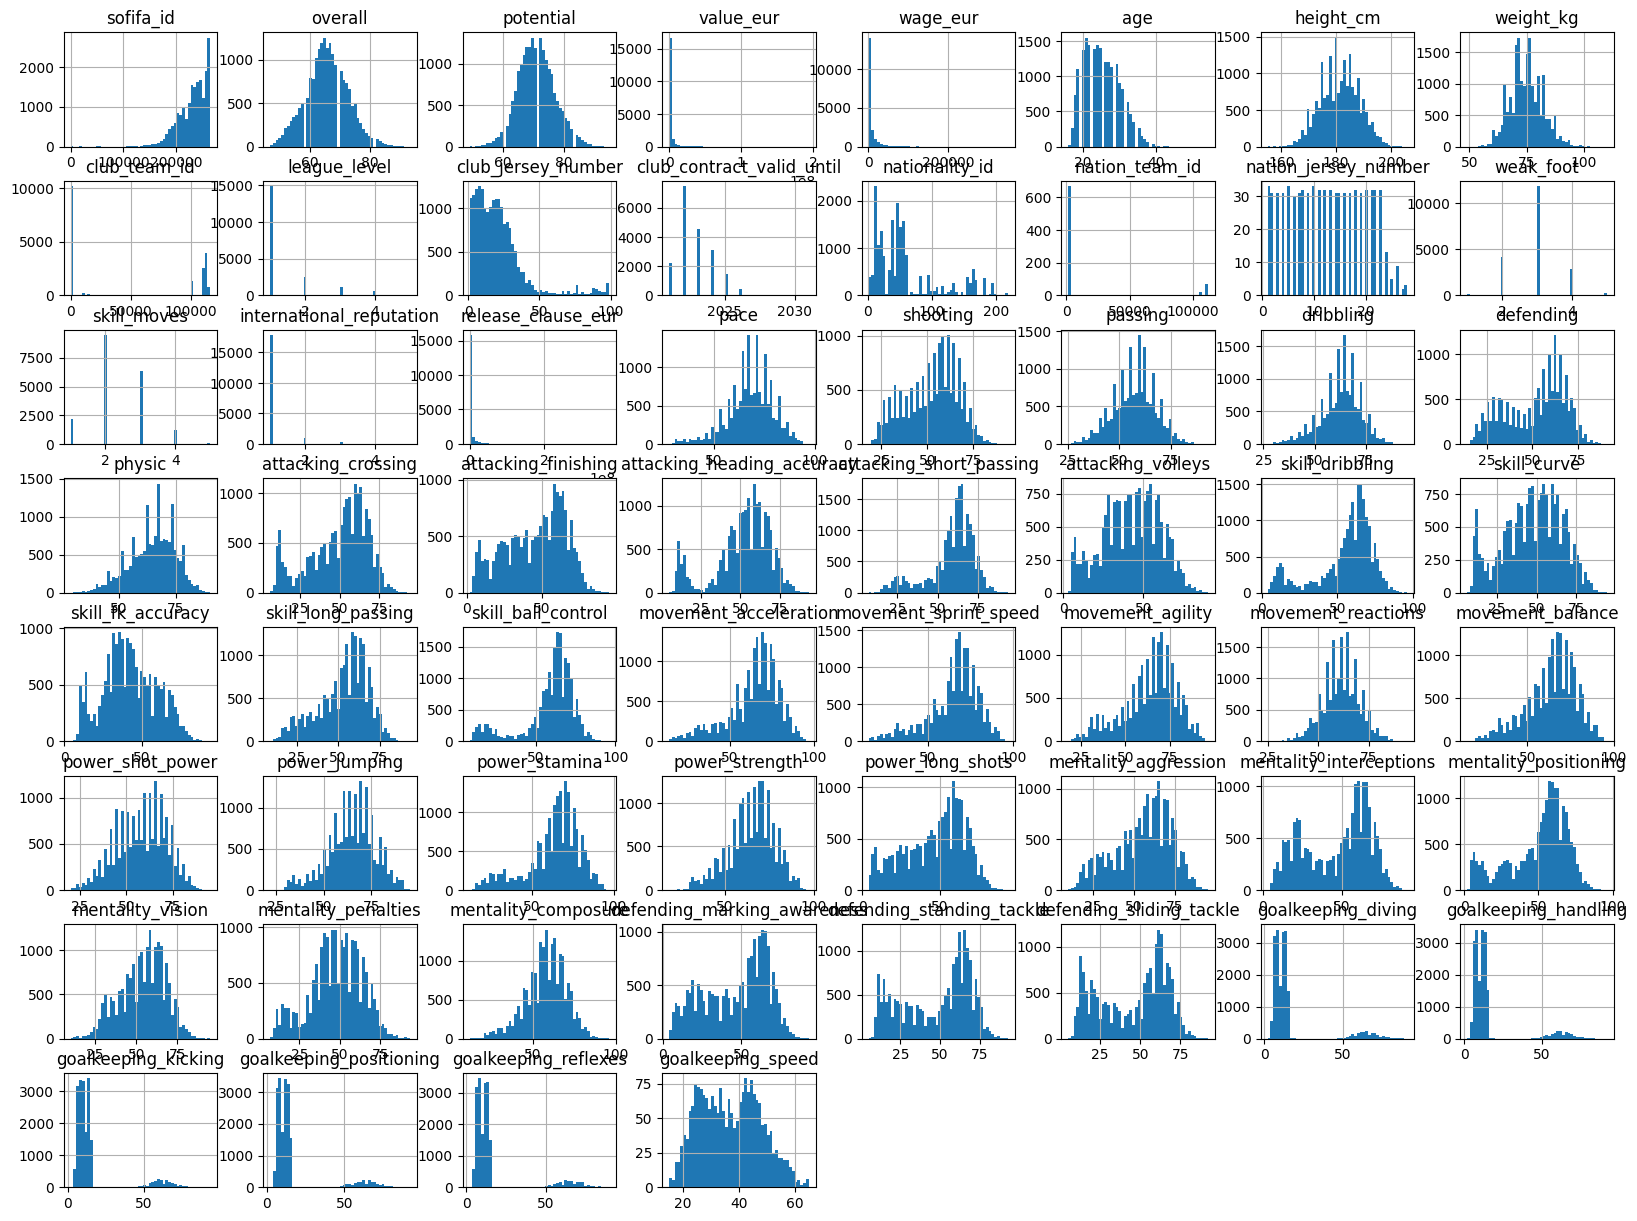

In [15]:
players_22.hist(bins=50, figsize=(20,15))
plt.show()

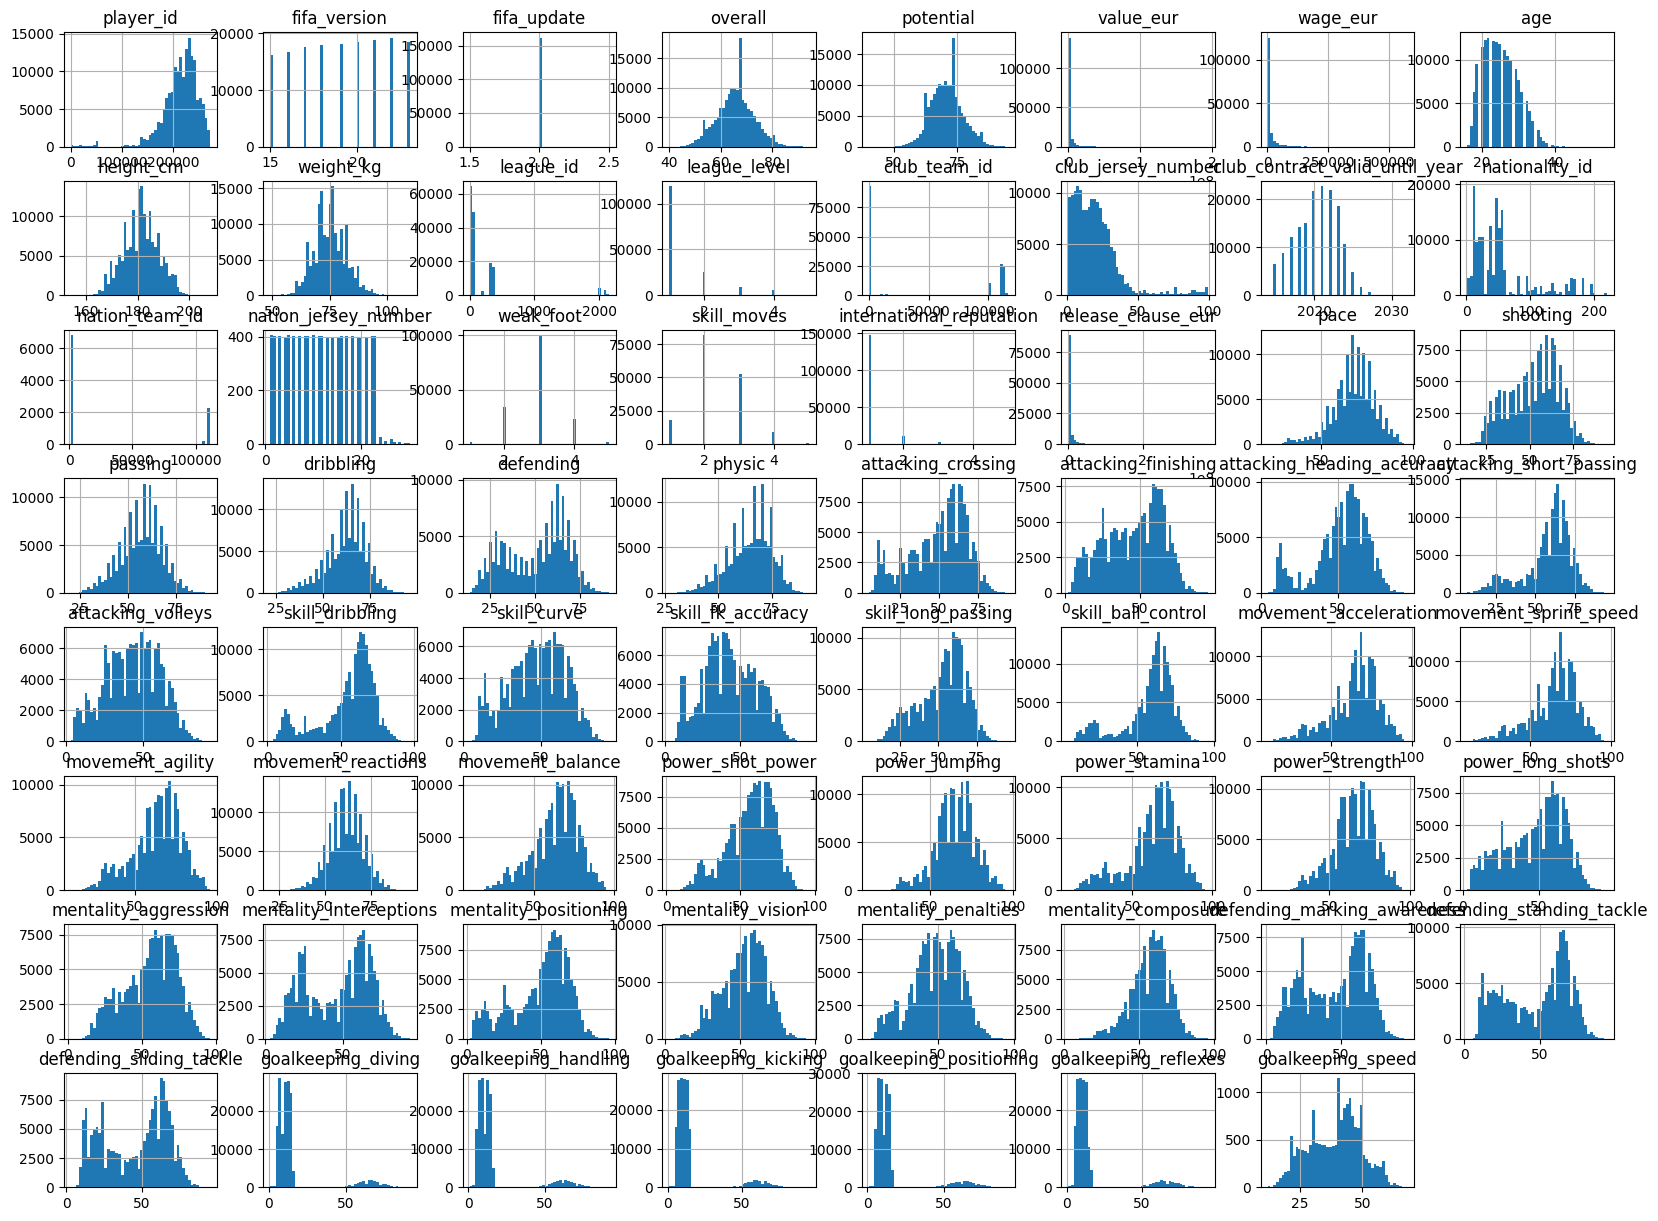

In [16]:
male_players.hist(bins=50, figsize=(20,15))
plt.show()

Rename the overall column to overall rating

In [17]:
# Rename the column: overall to overall_rating

male_players.rename(columns={'overall':'overall_rating', },inplace=True)
players_22.rename(columns={'overall':'overall_rating', },inplace=True)

Dropping some redundant columns





In [18]:
# Removing columns with more than 30% missing values and also selecting columns without any NaN values
male_players = male_players.loc[:, (male_players.isnull().mean() <= 0.3) | (male_players.isnull().sum() == 0)]
players_22 = players_22.loc[:, (players_22.isnull().mean() <= 0.3) | (players_22.isnull().sum() == 0)]

In [19]:
# Drop the following columns in male_players:

male_players.drop(['mentality_composure'], axis=1, inplace=True)
male_players.drop(['player_id'], axis=1, inplace=True)
male_players.drop(['nationality_id'], axis=1, inplace=True)
male_players.drop(['club_team_id'], axis=1, inplace=True)
male_players.drop(['league_id'], axis=1, inplace=True)

In [20]:
# Drop the following columns in players_22:
players_22.drop(['sofifa_id'], axis=1, inplace=True)

In [21]:
male_players.shape

(161583, 97)

In [22]:
players_22.shape

(19239, 101)

Checking for null values

In [23]:
# for col in male_players:
male_players.isnull().sum()

player_url          0
fifa_version        0
fifa_update         0
fifa_update_date    0
short_name          0
                   ..
cb                  0
rcb                 0
rb                  0
gk                  0
player_face_url     0
Length: 97, dtype: int64

In [24]:
# for col in players_22:
players_22.isnull().sum()

player_url           0
short_name           0
long_name            0
player_positions     0
overall_rating       0
                    ..
gk                   0
player_face_url      0
club_logo_url       61
club_flag_url       61
nation_flag_url      0
Length: 101, dtype: int64

In [25]:
# Print the columns names containing null values or missing values in the form of a list

# For male_players
missing_values_for_male_players = male_players.isnull().sum()
columns_with_missing_values_for_male_players = missing_values_for_male_players[missing_values_for_male_players > 0].index.tolist()

# For players_22
missing_values_for_players_22 = players_22.isnull().sum()
columns_with_missing_values_for_players_22 = missing_values_for_players_22[missing_values_for_players_22 > 0].index.tolist()

print(columns_with_missing_values_for_male_players,"\n")
print(columns_with_missing_values_for_players_22)

['value_eur', 'wage_eur', 'league_name', 'league_level', 'club_name', 'club_position', 'club_jersey_number', 'club_joined_date', 'club_contract_valid_until_year', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic'] 

['value_eur', 'wage_eur', 'club_team_id', 'club_name', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_joined', 'club_contract_valid_until', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'club_logo_url', 'club_flag_url']


Extracting Non-Categorical Features

In [26]:
# Keep the following categorical features for male_players
preferred_foot_for_male_players = male_players['preferred_foot']
work_rate_for_male_players = male_players['work_rate']

# Keep the following categorical features for players_22
preferred_foot_for_players_22 = players_22['preferred_foot']
work_rate_for_players_22 = players_22['work_rate']

In [27]:
# Extract numerical features

num_cols_for_male_players = male_players.select_dtypes(include=['number']).columns
num_cols_for_players_22 = players_22.select_dtypes(include=['number']).columns
print(num_cols_for_male_players, "\n")
print(num_cols_for_players_22)

Index(['fifa_version', 'fifa_update', 'overall_rating', 'potential',
       'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'league_level', 'club_jersey_number', 'club_contract_valid_until_year',
       'weak_foot', 'skill_moves', 'international_reputation', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'defending_marking_awareness', 'def

In [28]:
male_players = male_players[num_cols_for_male_players].head()
male_players

,fifa_version,fifa_update,overall_rating,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until_year,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,15,2,93,95,100500000.0,550000.0,27,169,67,1.0,10.0,2018.0,3,4,5,93.0,89.0,86.0,96.0,27.0,63.0,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,25,21,20,6,11,15,14,8
1,15,2,92,92,79000000.0,375000.0,29,185,80,1.0,7.0,2018.0,4,5,5,93.0,93.0,81.0,91.0,32.0,79.0,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,22,31,23,7,11,15,14,11
2,15,2,90,90,54500000.0,275000.0,30,180,80,1.0,10.0,2017.0,2,4,5,93.0,86.0,83.0,92.0,32.0,64.0,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,29,26,26,10,8,11,5,15
3,15,2,90,90,52500000.0,275000.0,32,195,95,1.0,10.0,2016.0,4,4,5,76.0,91.0,81.0,86.0,34.0,86.0,76,91,76,84,92,88,80,80,76,90,74,77,86,85,41,93,72,78,93,88,84,20,86,83,91,25,41,27,13,15,10,9,12
4,15,2,90,90,63500000.0,300000.0,28,193,92,1.0,1.0,2019.0,4,1,5,NaN,NaN,NaN,NaN,NaN,NaN,25,25,25,42,25,25,25,25,41,31,58,61,43,89,35,42,78,44,83,25,29,30,25,20,37,25,25,25,87,85,92,90,86


In [29]:
players_22 = players_22[num_cols_for_players_22].head()
players_22

,overall_rating,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_jersey_number,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,93,93,78000000.0,320000.0,34,170,72,73.0,1.0,30.0,2023.0,52,4,4,5,144300000.0,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8
1,92,92,119500000.0,270000.0,32,185,81,21.0,1.0,9.0,2023.0,37,4,4,5,197200000.0,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,91,91,45000000.0,270000.0,36,187,83,11.0,1.0,7.0,2023.0,38,4,5,5,83300000.0,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11
3,91,91,129000000.0,270000.0,29,175,68,73.0,1.0,10.0,2025.0,54,5,5,5,238700000.0,91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11
4,91,91,125500000.0,350000.0,30,181,70,10.0,1.0,17.0,2025.0,7,5,4,4,232200000.0,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13


In [30]:
# Print the columns names containing null values or missing values in the form of a list

# For male_players
missing_values_for_male_players = male_players.isnull().sum()
columns_with_missing_values_for_male_players = missing_values_for_male_players[missing_values_for_male_players > 0].index.tolist()

print(columns_with_missing_values_for_male_players,"\n")

['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic'] 



In [31]:
# Print the columns names containing null values or missing values in the form of a list

# For male_players
missing_values_for_players_22 = players_22.isnull().sum()
columns_with_missing_values_for_players_22 = missing_values_for_players_22[missing_values_for_players_22 > 0].index.tolist()

print(columns_with_missing_values_for_players_22)

[]


In [32]:
# # Fill NaN values with the mean of the column


# male_players = male_players.fillna(male_players.mean())

In [33]:
#  Print the columns names containing null values or missing values in the form of a list

# For male_players
missing_values_for_male_players = male_players.isnull().sum()
columns_with_missing_values_for_male_players = missing_values_for_male_players[missing_values_for_male_players > 0].index.tolist()

print(columns_with_missing_values_for_male_players,"\n")

[] 



In [34]:
male_players.head()

,fifa_version,fifa_update,overall_rating,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until_year,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,15,2,93,95,100500000.0,550000.0,27,169,67,1.0,10.0,2018.0,3,4,5,93.00,89.00,86.00,96.00,27.00,63.0,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,25,21,20,6,11,15,14,8
1,15,2,92,92,79000000.0,375000.0,29,185,80,1.0,7.0,2018.0,4,5,5,93.00,93.00,81.00,91.00,32.00,79.0,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,22,31,23,7,11,15,14,11
2,15,2,90,90,54500000.0,275000.0,30,180,80,1.0,10.0,2017.0,2,4,5,93.00,86.00,83.00,92.00,32.00,64.0,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,29,26,26,10,8,11,5,15
3,15,2,90,90,52500000.0,275000.0,32,195,95,1.0,10.0,2016.0,4,4,5,76.00,91.00,81.00,86.00,34.00,86.0,76,91,76,84,92,88,80,80,76,90,74,77,86,85,41,93,72,78,93,88,84,20,86,83,91,25,41,27,13,15,10,9,12
4,15,2,90,90,63500000.0,300000.0,28,193,92,1.0,1.0,2019.0,4,1,5,88.75,89.75,82.75,91.25,31.25,73.0,25,25,25,42,25,25,25,25,41,31,58,61,43,89,35,42,78,44,83,25,29,30,25,20,37,25,25,25,87,85,92,90,86


In [35]:
players_22.head()

,overall_rating,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_jersey_number,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,93,93,78000000.0,320000.0,34,170,72,73.0,1.0,30.0,2023.0,52,4,4,5,144300000.0,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8
1,92,92,119500000.0,270000.0,32,185,81,21.0,1.0,9.0,2023.0,37,4,4,5,197200000.0,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,91,91,45000000.0,270000.0,36,187,83,11.0,1.0,7.0,2023.0,38,4,5,5,83300000.0,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11
3,91,91,129000000.0,270000.0,29,175,68,73.0,1.0,10.0,2025.0,54,5,5,5,238700000.0,91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11
4,91,91,125500000.0,350000.0,30,181,70,10.0,1.0,17.0,2025.0,7,5,4,4,232200000.0,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13


In [36]:
# Convert categorical features into numeric for male_players
preferred_foot_for_male_players = pd.get_dummies(preferred_foot_for_male_players, prefix='preferred_foot')
work_rate_for_male_players  = pd.get_dummies(work_rate_for_male_players , prefix='work_rate')


# Convert categorical features into numeric for players_22
preferred_foot_for_players_22 = pd.get_dummies(preferred_foot_for_players_22, prefix='preferred_foot')
work_rate_for_players_22 = pd.get_dummies(work_rate_for_players_22, prefix='work_rate')

In [37]:
preferred_foot_for_male_players

,preferred_foot_Left,preferred_foot_Right
0,True,False
1,False,True
2,True,False
3,False,True
4,False,True
...,...,...
161578,False,True
161579,True,False
161580,False,True
161581,False,True


In [38]:
work_rate_for_male_players

,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,False,False,False,False,False,False,False,True,False
1,False,True,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
161578,False,False,False,False,False,False,False,False,True
161579,False,False,False,False,False,False,False,False,True
161580,False,False,True,False,False,False,False,False,False
161581,False,False,False,False,False,False,False,False,True


In [39]:
preferred_foot_for_players_22

,preferred_foot_Left,preferred_foot_Right
0,True,False
1,False,True
2,False,True
3,False,True
4,False,True
...,...,...
19234,False,True
19235,False,True
19236,False,True
19237,False,True


In [40]:
work_rate_for_players_22

,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,False,False,False,False,False,False,False,True,False
1,False,False,True,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
19234,False,False,False,False,False,False,False,False,True
19235,False,False,False,False,False,False,False,False,True
19236,False,False,False,False,False,False,False,False,True
19237,False,False,False,False,False,False,False,False,True


In [41]:
male_players

,fifa_version,fifa_update,overall_rating,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until_year,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,15,2,93,95,100500000.0,550000.0,27,169,67,1.0,10.0,2018.0,3,4,5,93.00,89.00,86.00,96.00,27.00,63.0,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,25,21,20,6,11,15,14,8
1,15,2,92,92,79000000.0,375000.0,29,185,80,1.0,7.0,2018.0,4,5,5,93.00,93.00,81.00,91.00,32.00,79.0,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,22,31,23,7,11,15,14,11
2,15,2,90,90,54500000.0,275000.0,30,180,80,1.0,10.0,2017.0,2,4,5,93.00,86.00,83.00,92.00,32.00,64.0,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,29,26,26,10,8,11,5,15
3,15,2,90,90,52500000.0,275000.0,32,195,95,1.0,10.0,2016.0,4,4,5,76.00,91.00,81.00,86.00,34.00,86.0,76,91,76,84,92,88,80,80,76,90,74,77,86,85,41,93,72,78,93,88,84,20,86,83,91,25,41,27,13,15,10,9,12
4,15,2,90,90,63500000.0,300000.0,28,193,92,1.0,1.0,2019.0,4,1,5,88.75,89.75,82.75,91.25,31.25,73.0,25,25,25,42,25,25,25,25,41,31,58,61,43,89,35,42,78,44,83,25,29,30,25,20,37,25,25,25,87,85,92,90,86


In [42]:
players_22

,overall_rating,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_jersey_number,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,93,93,78000000.0,320000.0,34,170,72,73.0,1.0,30.0,2023.0,52,4,4,5,144300000.0,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8
1,92,92,119500000.0,270000.0,32,185,81,21.0,1.0,9.0,2023.0,37,4,4,5,197200000.0,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,91,91,45000000.0,270000.0,36,187,83,11.0,1.0,7.0,2023.0,38,4,5,5,83300000.0,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11
3,91,91,129000000.0,270000.0,29,175,68,73.0,1.0,10.0,2025.0,54,5,5,5,238700000.0,91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11
4,91,91,125500000.0,350000.0,30,181,70,10.0,1.0,17.0,2025.0,7,5,4,4,232200000.0,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13


In [43]:
# Print the columns names containing null values or missing values in the form of a list

# For male_players
missing_values_for_male_players = male_players.isnull().sum()
columns_with_missing_values_for_male_players = missing_values_for_male_players[missing_values_for_male_players > 0].index.tolist()

print(columns_with_missing_values_for_male_players,"\n")

[] 



In [44]:
# Join both numeric and non-numeric columns to form fully numeric columns
male_players = pd.concat([male_players, preferred_foot_for_male_players, work_rate_for_male_players,], axis=1)

players_22 = pd.concat([players_22, preferred_foot_for_players_22, work_rate_for_players_22], axis=1)


In [45]:
male_players.shape

(161583, 65)

In [46]:
players_22.shape

(19239, 67)

In [47]:
# male_players only has numeric features in the dataset. Lets impute the missing values if any.

# for male_players
imp = SimpleImputer()

# Fit and transform the data
try:
    imputed_data_for_male_players = imp.fit_transform(male_players)
    male_players = pd.DataFrame(imputed_data_for_male_players, columns=male_players.columns)
    print(male_players)
except ValueError as e:
    print("Error during imputation:", e)



        fifa_version  fifa_update  overall_rating  potential    value_eur  \
0               15.0          2.0            93.0       95.0  100500000.0   
1               15.0          2.0            92.0       92.0   79000000.0   
2               15.0          2.0            90.0       90.0   54500000.0   
3               15.0          2.0            90.0       90.0   52500000.0   
4               15.0          2.0            90.0       90.0   63500000.0   
...              ...          ...             ...        ...          ...   
161578          15.0          2.0            91.0       91.4   70000000.0   
161579          15.0          2.0            91.0       91.4   70000000.0   
161580          15.0          2.0            91.0       91.4   70000000.0   
161581          15.0          2.0            91.0       91.4   70000000.0   
161582          15.0          2.0            91.0       91.4   70000000.0   

        wage_eur   age  height_cm  weight_kg  league_level  \
0       55000

In [48]:
## At this point players_21 and players_22 only have numeric features in the dataset. Lets impute the missing values.

# for players_22
imp = SimpleImputer(strategy='most_frequent')
imputed_data_22 = imp.fit_transform(players_22)
players_22 = pd.DataFrame(imputed_data_22, columns=players_22.columns)


In [49]:
# Print the columns names containing null values or missing values in the form of a list

# For male_players
missing_values_for_male_players = male_players.isnull().sum()
columns_with_missing_values_for_male_players = missing_values_for_male_players[missing_values_for_male_players > 0].index.tolist()

print(columns_with_missing_values_for_male_players,"\n")

[] 



In [50]:
# Print the columns names containing null values or missing values in the form of a list

# For players_22
missing_values_for_players_22 = players_22.isnull().sum()
columns_with_missing_values_for_players_22 = missing_values_for_players_22[missing_values_for_players_22 > 0].index.tolist()

print(columns_with_missing_values_for_players_22)

[]


In [51]:
players_22

,overall_rating,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_jersey_number,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,preferred_foot_Left,preferred_foot_Right,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,93.0,93.0,78000000.0,320000.0,34.0,170.0,72.0,73.0,1.0,30.0,2023.0,52.0,4.0,4.0,5.0,144300000.0,85.0,92.0,91.0,95.0,34.0,65.0,85.0,95.0,70.0,91.0,88.0,96.0,93.0,94.0,91.0,96.0,91.0,80.0,91.0,94.0,95.0,86.0,68.0,72.0,69.0,94.0,44.0,40.0,93.0,95.0,75.0,96.0,20.0,35.0,24.0,6.0,11.0,15.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,92.0,92.0,119500000.0,270000.0,32.0,185.0,81.0,21.0,1.0,9.0,2023.0,37.0,4.0,4.0,5.0,197200000.0,78.0,92.0,79.0,86.0,44.0,82.0,71.0,95.0,90.0,85.0,89.0,85.0,79.0,85.0,70.0,88.0,77.0,79.0,77.0,93.0,82.0,90.0,85.0,76.0,86.0,87.0,81.0,49.0,95.0,81.0,90.0,88.0,35.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,91.0,91.0,45000000.0,270000.0,36.0,187.0,83.0,11.0,1.0,7.0,2023.0,38.0,4.0,5.0,5.0,83300000.0,87.0,94.0,80.0,88.0,34.0,75.0,87.0,95.0,90.0,80.0,86.0,88.0,81.0,84.0,77.0,88.0,85.0,88.0,86.0,94.0,74.0,94.0,95.0,77.0,77.0,93.0,63.0,29.0,95.0,76.0,88.0,95.0,24.0,32.0,24.0,7.0,11.0,15.0,14.0,11.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.0,91.0,129000000.0,270000.0,29.0,175.0,68.0,73.0,1.0,10.0,2025.0,54.0,5.0,5.0,5.0,238700000.0,91.0,83.0,86.0,94.0,37.0,63.0,85.0,83.0,63.0,86.0,86.0,95.0,88.0,87.0,81.0,95.0,93.0,89.0,96.0,89.0,84.0,80.0,64.0,81.0,53.0,81.0,63.0,37.0,86.0,90.0,93.0,93.0,35.0,32.0,29.0,9.0,9.0,15.0,15.0,11.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,91.0,91.0,125500000.0,350000.0,30.0,181.0,70.0,10.0,1.0,17.0,2025.0,7.0,5.0,4.0,4.0,232200000.0,76.0,86.0,93.0,88.0,64.0,78.0,94.0,82.0,55.0,94.0,82.0,88.0,85.0,83.0,93.0,91.0,76.0,76.0,79.0,91.0,78.0,91.0,63.0,89.0,74.0,91.0,76.0,66.0,88.0,94.0,83.0,89.0,68.0,65.0,53.0,15.0,13.0,5.0,10.0,13.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,91.0,91.0,45000000.0,270000.0,29.0,170.0,68.0,73.0,1.0,7.0,2023.0,7.0,4.0,4.0,5.0,83300000.0,76.0,92.0,79.0,88.0,34.0,63.0,85.0,95.0,90.0,80.0,86.0,88.0,79.0,83.0,70.0,88.0,76.0,76.0,77.0,94.0,74.0,80.0,63.0,72.0,53.0,81.0,63.0,29.0,95.0,76.0,75.0,88.0,35.0,32.0,24.0,15.0,11.0,15.0,14.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19235,91.0,91.0,45000000.0,270000.0,29.0,170.0,68.0,73.0,1.0,7.0,2023.0,7.0,4.0,4.0,5.0,83300000.0,76.0,92.0,79.0,88.0,34.0,63.0,85.0,95.0,90.0,80.0,86.0,88.0,79.0,83.0,70.0,88.0,76.0,76.0,77.0,94.0,74.0,80.0,63.0,72.0,53.0,81.0,63.0,29.0,95.0,76.0,75.0,88.0,35.0,32.0,24.0,15.0,11.0,15.0,14.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19236,91.0,91.0,45000000.0,270000.0,29.0,170.0,68.0,73.0,1.0,7.0,2023.0,7.0,4.0,4.0,5.0,83300000.0,76.0,92.0,79.0,88.0,34.0,63.0,85.0,95.0,90.0,80.0,86.0,88.0,79.0,83.0,7

In [52]:
male_players

,fifa_version,fifa_update,overall_rating,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until_year,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,preferred_foot_Left,preferred_foot_Right,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,15.0,2.0,93.0,95.0,100500000.0,550000.0,27.0,169.0,67.0,1.0,10.0,2018.0,3.0,4.0,5.0,93.00,89.00,86.00,96.00,27.00,63.0,84.0,94.0,71.0,89.0,85.0,96.0,89.0,90.0,76.0,96.0,96.0,90.0,94.0,94.0,95.0,80.0,73.0,77.0,60.0,88.0,48.0,22.0,92.0,90.0,76.0,25.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,15.0,2.0,92.0,92.0,79000000.0,375000.0,29.0,185.0,80.0,1.0,7.0,2018.0,4.0,5.0,5.0,93.00,93.00,81.00,91.00,32.00,79.0,83.0,95.0,86.0,82.0,87.0,93.0,88.0,79.0,72.0,92.0,91.0,94.0,93.0,90.0,63.0,94.0,94.0,89.0,79.0,93.0,63.0,24.0,91.0,81.0,85.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15.0,2.0,90.0,90.0,54500000.0,275000.0,30.0,180.0,80.0,1.0,10.0,2017.0,2.0,4.0,5.0,93.00,86.00,83.00,92.00,32.00,64.0,80.0,85.0,50.0,86.0,86.0,93.0,85.0,83.0,76.0,90.0,93.0,93.0,93.0,89.0,91.0,86.0,61.0,78.0,65.0,90.0,47.0,39.0,89.0,84.0,80.0,29.0,26.0,26.0,10.0,8.0,11.0,5.0,15.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.0,2.0,90.0,90.0,52500000.0,275000.0,32.0,195.0,95.0,1.0,10.0,2016.0,4.0,4.0,5.0,76.00,91.00,81.00,86.00,34.00,86.0,76.0,91.0,76.0,84.0,92.0,88.0,80.0,80.0,76.0,90.0,74.0,77.0,86.0,85.0,41.0,93.0,72.0,78.0,93.0,88.0,84.0,20.0,86.0,83.0,91.0,25.0,41.0,27.0,13.0,15.0,10.0,9.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,15.0,2.0,90.0,90.0,63500000.0,300000.0,28.0,193.0,92.0,1.0,1.0,2019.0,4.0,1.0,5.0,88.75,89.75,82.75,91.25,31.25,73.0,25.0,25.0,25.0,42.0,25.0,25.0,25.0,25.0,41.0,31.0,58.0,61.0,43.0,89.0,35.0,42.0,78.0,44.0,83.0,25.0,29.0,30.0,25.0,20.0,37.0,25.0,25.0,25.0,87.0,85.0,92.0,90.0,86.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161578,15.0,2.0,91.0,91.4,70000000.0,355000.0,29.2,184.4,82.8,1.0,7.6,2017.6,3.4,3.6,5.0,88.75,89.75,82.75,91.25,31.25,73.0,69.6,78.0,61.6,76.6,75.0,79.0,73.4,71.4,68.2,79.8,82.4,83.0,81.8,89.4,65.0,79.0,75.6,73.2,76.0,76.8,54.2,27.0,76.6,71.6,73.8,25.2,28.8,24.2,24.6,26.0,28.6,26.4,26.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
161579,15.0,2.0,91.0,91.4,70000000.0,355000.0,29.2,184.4,82.8,1.0,7.6,2017.6,3.4,3.6,5.0,88.75,89.75,82.75,91.25,31.25,73.0,69.6,78.0,61.6,76.6,75.0,79.0,73.4,71.4,68.2,79.8,82.4,83.0,81.8,89.4,65.0,79.0,75.6,73.2,76.0,76.8,54.2,27.0,76.6,71.6,73.8,25.2,28.8,24.2,24.6,26.0,28.6,26.4,26.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
161580,15.0,2.0,91.0,91.4,70000000.0,355000.0,29.2,184.4,82.8,1.0,7.6,2017.6,3.4,3.6,5.0,88.75,89.75,82.75,91.25,31.25,73.0,69.6,78.0,61.6,76.6,75.0,79.0,73.4,71.4,68.2,79.8,82.4,83.0,81.8,89.4,65.0,79.0,75.6,73.2,76.0,76.8,54.2,27.0,76.6,71.6,73.8,25.2,28.8,24.2,24.6,26.0,28.6,26.4,26.4,0.0,1.0,0

Feature Selection

In [53]:
# Calculate the correlation between each feature and the target variable
correlation_matrix = male_players.corr()
target_correlation = correlation_matrix['overall_rating'].drop('overall_rating')

# Select the top-k features with the highest absolute correlation
k = 20
top_k_features = target_correlation[target_correlation > 0.5].abs().nlargest(k).index

# Collect the column names of top_k_features in a list and store it in the 'selected_features' variable
selected_features = top_k_features.tolist()

# Display the selected features and their correlation with the target variable
print(f"\nTop {k} features with maximum correlation with the target variable:\n")
print(male_players[top_k_features])

'''
#The correlation matrix produces the some results for players_22

# Calculate the correlation between each feature and the target variable
correlation_matrix = players_22.corr()
target_correlation = correlation_matrix['overall_rating'].drop('overall_rating')

# Select the top-k features with the highest absolute correlation
k = 20
top_k_features = target_correlation[target_correlation > 0.5].abs().nlargest(k).index

# Collect the column names of top_k_features in a list and store it in the 'selected_features' variable
selected_features = top_k_features.tolist()

# Display the selected features and their correlation with the target variable
print(f"\nTop {k} features with maximum correlation with the target variable:\n")
print(players_22[top_k_features])

print(selected_features)

'''


Top 20 features with maximum correlation with the target variable:

        potential    value_eur  wage_eur  movement_reactions  dribbling  \
0            95.0  100500000.0  550000.0                94.0      96.00   
1            92.0   79000000.0  375000.0                90.0      91.00   
2            90.0   54500000.0  275000.0                89.0      92.00   
3            90.0   52500000.0  275000.0                85.0      86.00   
4            90.0   63500000.0  300000.0                89.0      91.25   
...           ...          ...       ...                 ...        ...   
161578       91.4   70000000.0  355000.0                89.4      91.25   
161579       91.4   70000000.0  355000.0                89.4      91.25   
161580       91.4   70000000.0  355000.0                89.4      91.25   
161581       91.4   70000000.0  355000.0                89.4      91.25   
161582       91.4   70000000.0  355000.0                89.4      91.25   

        movement_acceleration 

'\n#The correlation matrix produces the some results for players_22\n\n# Calculate the correlation between each feature and the target variable\ncorrelation_matrix = players_22.corr()\ntarget_correlation = correlation_matrix[\'overall_rating\'].drop(\'overall_rating\')\n\n# Select the top-k features with the highest absolute correlation\nk = 20\ntop_k_features = target_correlation[target_correlation > 0.5].abs().nlargest(k).index\n\n# Collect the column names of top_k_features in a list and store it in the \'selected_features\' variable\nselected_features = top_k_features.tolist()\n\n# Display the selected features and their correlation with the target variable\nprint(f"\nTop {k} features with maximum correlation with the target variable:\n")\nprint(players_22[top_k_features])\n\nprint(selected_features)\n\n'

In [54]:
# List of features that would be trained
selected_features

['potential',
 'value_eur',
 'wage_eur',
 'movement_reactions',
 'dribbling',
 'movement_acceleration',
 'attacking_heading_accuracy',
 'movement_balance',
 'movement_sprint_speed',
 'passing',
 'pace']

In [55]:
# Select the the independent (X) and dependent (Y) variables
X = male_players[selected_features]
y = male_players['overall_rating']

In [56]:
X.head()

,potential,value_eur,wage_eur,movement_reactions,dribbling,movement_acceleration,attacking_heading_accuracy,movement_balance,movement_sprint_speed,passing,pace
0,95.0,100500000.0,550000.0,94.0,96.00,96.0,71.0,95.0,90.0,86.00,93.00
1,92.0,79000000.0,375000.0,90.0,91.00,91.0,86.0,63.0,94.0,81.00,93.00
2,90.0,54500000.0,275000.0,89.0,92.00,93.0,50.0,91.0,93.0,83.00,93.00
3,90.0,52500000.0,275000.0,85.0,86.00,74.0,76.0,41.0,77.0,81.00,76.00
4,90.0,63500000.0,300000.0,89.0,91.25,58.0,25.0,35.0,61.0,82.75,88.75


In [57]:
y.head()

0    93.0
1    92.0
2    90.0
3    90.0
4    90.0
Name: overall_rating, dtype: float64

In [78]:
X.shape

(161583, 11)

In [93]:
y.shape

(161583,)

**Feature Scaling and Training**

In [92]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [91]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# from collections import Counter

# # Find the number of samples in the smallest class
# counter = Counter(y_train)
# min_class_samples = min(counter.values())

# # Ensure that k_neighbors is set to a value <= the number of samples in the smallest class
# smote = SMOTE(random_state=42, k_neighbors=min(min_class_samples - 1, 5))

# # Resample the training data
# x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [62]:
## View the dimension of the training data and testing data
x_train.shape, y_test.shape, y_train.shape, x_test.shape

((129266, 11), (32317,), (129266,), (32317, 11))

**Ensemble Models**

In [63]:
# Model 1: Train RandomForest, XGBoost and Gradient Boost Regressors models with cv and grid search:
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'GradientBoost': GradientBoostingRegressor()
}

params = {
    'RandomForest': {'n_estimators': [4, 5], 'max_depth': [None, 5]},
    'XGBoost': {'n_estimators': [5, 6], 'learning_rate': [0.01, 0.1]},
    'GradientBoost': {'n_estimators': [4, 6], 'learning_rate': [0.01, 0.1]}
}

for name, model in models.items():
    gs = GridSearchCV(model, params[name], cv=5)
    gs.fit(x_train, y_train)
    # Make predictions using the best model from GridSearchCV
    y_pred = gs.predict(x_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nBest parameters for {name}: {gs.best_params_}")
    print(f"Validation score for {name}: {gs.score(x_test, y_test)}")
    print(f"mean_absolute_error for {name}: {mae}")
    print(f"mean_squared_error for {name}: {mse}",)
    print(f"r2_score for {name}: {r2}\n")


Best parameters for RandomForest: {'max_depth': 5, 'n_estimators': 4}
Validation score for RandomForest: 0.1499947395781761
mean_absolute_error for RandomForest: 7.73586657177337e-05
mean_squared_error for RandomForest: 0.0001315097317201473
r2_score for RandomForest: 0.1499947395781761


Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 6}
Validation score for XGBoost: 0.3104973362891621
mean_absolute_error for XGBoost: 8.177288792107289e-05
mean_squared_error for XGBoost: 0.00010667735194949285
r2_score for XGBoost: 0.3104973362891621


Best parameters for GradientBoost: {'learning_rate': 0.01, 'n_estimators': 6}
Validation score for GradientBoost: 0.053465993023697256
mean_absolute_error for GradientBoost: 9.710129039188433e-05
mean_squared_error for GradientBoost: 0.00014644430936777483
r2_score for GradientBoost: 0.053465993023697256



In [64]:
'''
Mean Squared Error (MSE) is a common metric for regression problems,
and it measures the average of the squared differences between the
predicted values and the actual values. A lower MSE indicates that
the model's predictions are, on average, closer to the true values.
Lower MSE often corresponds to better model performance.
'''

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    random_state=42
)

# Train the model
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mean_absolute_error:",mae)
print("mean_squared_error:",mse)
print("r2_score:",r2)


mean_absolute_error: 6.529071386576722e-05
mean_squared_error: 9.00609586285856e-05
r2_score: 0.41789639753936014


In [65]:
# Model 2: VotingClassifier

decision_tree = DecisionTreeClassifier(random_state=42, criterion='entropy')
knn = KNeighborsClassifier(n_neighbors=8)
svm = SVC(probability=True, random_state=42)

voting_classifier = VotingClassifier(estimators=[
    ('decision_tree', decision_tree),
    ('knn', knn),
    ('svm', svm)
], voting='soft')

for model in (decision_tree, knn, svm,voting_classifier):
  model.fit(x_train,y_train)
  y_pred=model.predict(x_test)
  print(model.__class__.__name__,accuracy_score(y_pred,y_test))

DecisionTreeClassifier 0.9999690565337129
KNeighborsClassifier 0.9999381130674259
SVC 0.9999690565337129
VotingClassifier 0.9999690565337129


In [66]:
# Model 3: RandomForestClassifier

rfc=RandomForestClassifier(n_estimators=20, max_depth=3, criterion='entropy')

# Perform cross-validation
cv_scores = cross_val_score(rfc, x_train, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"\nMean cross-validation score: {cv_scores.mean()}")

# Fit the model
rfc.fit(x_train,y_train)
y_pred=rfc.predict(x_test)
accuracy_score(y_pred,y_test)
print('\nAccuracy of the model:',accuracy_score(y_pred,y_test))

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nmean_absolute_error of the model:",mae)
print("\nmean_squared_error of the model:",mse)
print("\nr2_score of the model:",r2)

# Fine-tune the model (RandomForestClassifier) with GridSearchCV
n_estimators_range = list(range(1, 31))

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=n_estimators_range)

grid = GridSearchCV(RandomForestClassifier(max_depth=3, criterion='entropy'), param_grid, cv=10, scoring='accuracy')
grid.fit(x_train, y_train)

rfc=RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'], max_depth=3, criterion='entropy')
rfc.fit(x_train,y_train)
y_pred=rfc.predict(x_test)
accuracy_score(y_pred,y_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Examine the best model
print("\ngrid.best_score:",grid.best_score_)
print("\ngrid.best_params:",grid.best_params_)
print("\ngrid.best_estimator:",grid.best_estimator_)
print("\nAccuracy of the best model:", accuracy_score(y_pred,y_test))
print("\nmean_absolute_error of the best model:",mae)
print("\nmean_squared_error of the best model:",mse)
print("\nr2_score of the best model:",r2)


Cross-validation scores: [0.99996132 1.         1.         0.99996132 0.99996132]

Mean cross-validation score: 0.9999767921609

Accuracy of the model: 0.9999381130674259

mean_absolute_error of the model: 9.283039886128045e-05

mean_squared_error of the model: 0.0001547173314354674

r2_score of the model: -6.188731557665861e-06

grid.best_score: 0.999976792759341

grid.best_params: {'n_estimators': 1}

grid.best_estimator: RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=1)

Accuracy of the best model: 0.9999690565337129

mean_absolute_error of the best model: 6.188693257418696e-05

mean_squared_error of the best model: 0.00012377386514837393

r2_score of the best model: 0.19999504901475396


In [67]:
# correlation between variables in selected_features and the target variable; overall_rating
for name, score in zip(x_train.columns, rfc.feature_importances_):
  print(name, score)

potential 0.0
value_eur 0.38339446311685454
wage_eur 0.0
movement_reactions 0.0
dribbling 0.0
movement_acceleration 0.0
attacking_heading_accuracy 0.0
movement_balance 0.6166055368831455
movement_sprint_speed 0.0
passing 0.0
pace 0.0


**Testing the models using players_22**

In [68]:
x_test_22 = players_22[selected_features]
y_test_22 = players_22['overall_rating']

scaler = StandardScaler()
x_test_22_scaled = scaler.fit_transform(x_test_22)
x_test_22 = pd.DataFrame(x_test_22_scaled, columns=x_test_22.columns)

In [69]:
# Model 1: Testing players_22 on RandomForest, XGBoost, Gradient Boost Regressors
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'GradientBoost': GradientBoostingRegressor()
}

params = {
    'RandomForest': {'n_estimators': [4, 5], 'max_depth': [None, 5]},
    'XGBoost': {'n_estimators': [5, 6], 'learning_rate': [0.01, 0.1]},
    'GradientBoost': {'n_estimators': [4, 6], 'learning_rate': [0.01, 0.1]}
}

for name, m in models.items():
    gs = GridSearchCV(m, params[name], cv=5)
    gs.fit(x_train, y_train)
    # Make predictions using the best model from GridSearchCV
    y_pred = gs.predict(x_test_22)

    # Evaluate the model
    mae = mean_absolute_error(y_test_22, y_pred)
    mse = mean_squared_error(y_test_22, y_pred)
    r2 = r2_score(y_test_22, y_pred)

    #print('\nAccuracy: {}'.format(nb_model.score(x_test, y_test)))
    print(f"\nBest parameters for {name}: {gs.best_params_}")
    print(f"Validation score for {name}: {gs.score(x_test_22, y_test_22)}")
    #print()
    print(f"mean_absolute_error for {name}: {mae}")
    print(f"mean_squared_error for {name}: {mse}",)
    print(f"r2_score for {name}: {r2}\n")


Best parameters for RandomForest: {'max_depth': 5, 'n_estimators': 4}
Validation score for RandomForest: 0.17492280581373632
mean_absolute_error for RandomForest: 0.0001559332605644784
mean_squared_error for RandomForest: 0.0002144082332761578
r2_score for RandomForest: 0.17492280581373632


Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 6}
Validation score for XGBoost: -441.85074790056836
mean_absolute_error for XGBoost: 0.3390747840429667
mean_squared_error for XGBoost: 0.11508116710949906
r2_score for XGBoost: -441.85074790056836


Best parameters for GradientBoost: {'learning_rate': 0.1, 'n_estimators': 6}
Validation score for GradientBoost: 0.07585988657448361
mean_absolute_error for GradientBoost: 0.00017482292853304054
mean_squared_error for GradientBoost: 0.0002401511645399589
r2_score for GradientBoost: 0.07585988657448361



In [70]:
# Model 2: Testing players_22 on VotingClassifier

decision_tree = DecisionTreeClassifier(random_state=42, criterion='entropy')
knn = KNeighborsClassifier(n_neighbors=8)
svm = SVC(probability=True, random_state=42)

voting_classifier = VotingClassifier(estimators=[
    ('decision_tree', decision_tree),
    ('knn', knn),
    ('svm', svm)
], voting='soft')

for model in (decision_tree, knn, svm,voting_classifier):
  model.fit(x_train,y_train)
  y_pred=model.predict(x_test_22)
  print(model.__class__.__name__,accuracy_score(y_pred,y_test_22))

DecisionTreeClassifier 0.999792088985914
KNeighborsClassifier 0.999896044492957
SVC 0.9997401112323925
VotingClassifier 0.999792088985914


In [71]:
# Model 3: Testing players_22 on RandomForestClassifier

rfc=RandomForestClassifier(n_estimators=20, max_depth=3, criterion='entropy')

# Perform cross-validation
cv_scores = cross_val_score(rfc, x_train, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"\nMean cross-validation score: {cv_scores.mean()}")

# Fit the model
rfc.fit(x_train,y_train)
y_pred=rfc.predict(x_test_22)
accuracy_score(y_pred,y_test_22)
print('\nAccuracy of the model:',accuracy_score(y_pred,y_test_22))

# Evaluate the model
mae = mean_absolute_error(y_test_22, y_pred)
mse = mean_squared_error(y_test_22, y_pred)
r2 = r2_score(y_test_22, y_pred)
print("\nmean_absolute_error of the model:",mae)
print("\nmean_squared_error of the model:",mse)
print("\nr2_score of the model:",r2)

# Fine-tune the model (RandomForestClassifier) with GridSearchCV
n_estimators_range = list(range(1, 31))

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=n_estimators_range)

grid = GridSearchCV(RandomForestClassifier(max_depth=3, criterion='entropy'), param_grid, cv=10, scoring='accuracy')
grid.fit(x_train, y_train)

rfc=RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'], max_depth=3, criterion='entropy')
rfc.fit(x_train,y_train)
y_pred=rfc.predict(x_test_22)
accuracy_score(y_pred,y_test_22)

# Evaluate the model
mae = mean_absolute_error(y_test_22, y_pred)
mse = mean_squared_error(y_test_22, y_pred)
r2 = r2_score(y_test_22, y_pred)

# Examine the best model
print("\ngrid.best_score:",grid.best_score_)
print("\ngrid.best_params:",grid.best_params_)
print("\ngrid.best_estimator:",grid.best_estimator_)
print("\nAccuracy of the best model:", accuracy_score(y_pred,y_test_22))
print("\nmean_absolute_error of the best model:",mae)
print("\nmean_squared_error of the best model:",mse)
print("\nr2_score of the best model:",r2)


Cross-validation scores: [0.99996132 1.         1.         0.99996132 0.99996132]

Mean cross-validation score: 0.9999767921609

Accuracy of the model: 0.999896044492957

mean_absolute_error of the model: 0.0001559332605644784

mean_squared_error of the model: 0.00025988876760746403

r2_score of the model: -9.356871062271566e-05

grid.best_score: 0.9999845285062273

grid.best_params: {'n_estimators': 1}

grid.best_estimator: RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=1)

Accuracy of the best model: 0.9998440667394355

mean_absolute_error of the best model: 0.00025988876760746403

mean_squared_error of the best model: 0.0005717552887364208

r2_score of the best model: -1.20020585116337


In [72]:
# correlation between variables in selected_features and the target variable; overall_rating
for name, score in zip(x_train.columns, rfc.feature_importances_):
  print(name, score)

potential 0.04686125379534341
value_eur 0.0
wage_eur 0.0
movement_reactions 0.0
dribbling 0.7373118828323756
movement_acceleration 0.0
attacking_heading_accuracy 0.0
movement_balance 0.0
movement_sprint_speed 0.0
passing 0.21582686337228102
pace 0.0


**Saving RandomForestRegressor model using pickle**

In [73]:
filename = 'player_rating_predictor.pkl'
pickle.dump(rf_model, open(filename, 'wb'))

In [74]:
loaded_model = pickle.load(open(filename, 'rb'))


In [75]:
y_pred = loaded_model.predict(x_test)

In [76]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mean_absolute_error:",mae)
print("mean_squared_error:",mse)
print("r2_score:",r2)

mean_absolute_error: 6.529071386576722e-05
mean_squared_error: 9.00609586285856e-05
r2_score: 0.41789639753936014


In [77]:
if isinstance(loaded_model, RandomForestRegressor):
    print("The model is a RandomForestRegressor.")
else:
    print("The model is not a RandomForestRegressor.")

The model is a RandomForestRegressor.
